# Reconstruccion de imágenes

In [403]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as color_cm
import numpy as np
from brian2 import *
import os

# Image folder
IMG_FOLDER = 'images'

Las imágenes a procesar corresponde a un conjunto de fotográfias de tamaño 200x200 (en total 40.000 píxeles), las cuales cuentan sólo con un canal (escala de grises). A continuación se muestran las imágenes utilizadas en el procesamiento: 

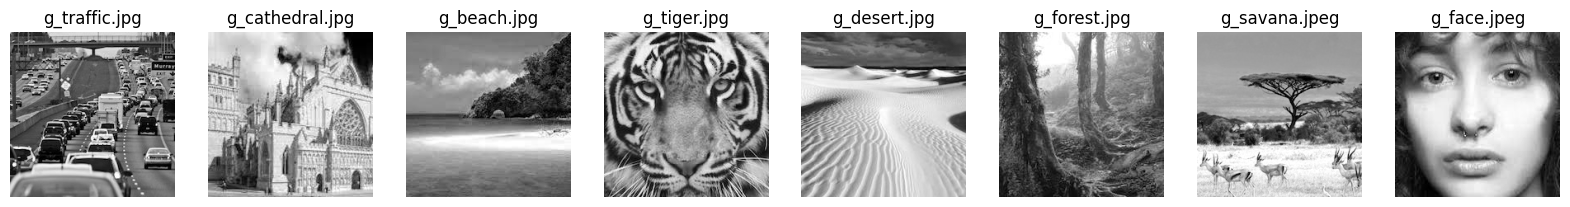

In [399]:
images = os.listdir(IMG_FOLDER)

fig, axs = plt.subplots(1,len(images))
fig.set_size_inches(20,5)

for i, image in enumerate(images):
    img_path = os.path.join(IMG_FOLDER, image)
    temp = cv2.imread(img_path,0)
    axs[i].imshow(temp,cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(image)
    

## Conversión de Imágenes a Corriente:

Las redes implementadas toman como entrada, la corriente derivada de la aplicación de un campo receptivo sobre cada píxel de la imagen, esta operación se puede describir mediante la siguiente ecuación:

$$ I(x,y) = \underbrace{D(x,y)}_{\text{Kernel}}  * L(x,y) $$

Donde $I(x,y)$ corresponde a la corriente obtenida en la posición $(x,y)$, el valor de intensidad del píxel en la posición $(x,y)$ es $L(x,y)$ y $D(x,y)$, que corresponde al *kernel* de convolución, modela el campo receptivo utilizado. 


### Campos receptivos

Los campos receptivos se pueden modelar como una diferencia de Gaussiangas (DoG) de acuerdo con la siguiente ecuación:

$$ D_{ON}(x,y) = \frac{1}{2\pi \sigma_{c}^{2}} \cdot e^{-\frac{x^{2} + y^{2}}{2\sigma_{c}^{2}}} - \frac{1}{2\pi \sigma_{s}^{2}} \cdot e^{-\frac{x^{2} + y^{2}}{2\sigma_{s}^{2}}} $$

Esta expresión define el campo receptivo Centro-ON ($D_{ON}(x,y)$), sin embargo, note que se puede modelar Centro-OFF ($D_{OFF}(x,y)$) de la siguiente manera:

$$ D_{OFF}(x,y) = -D_{ON}(x,y) $$



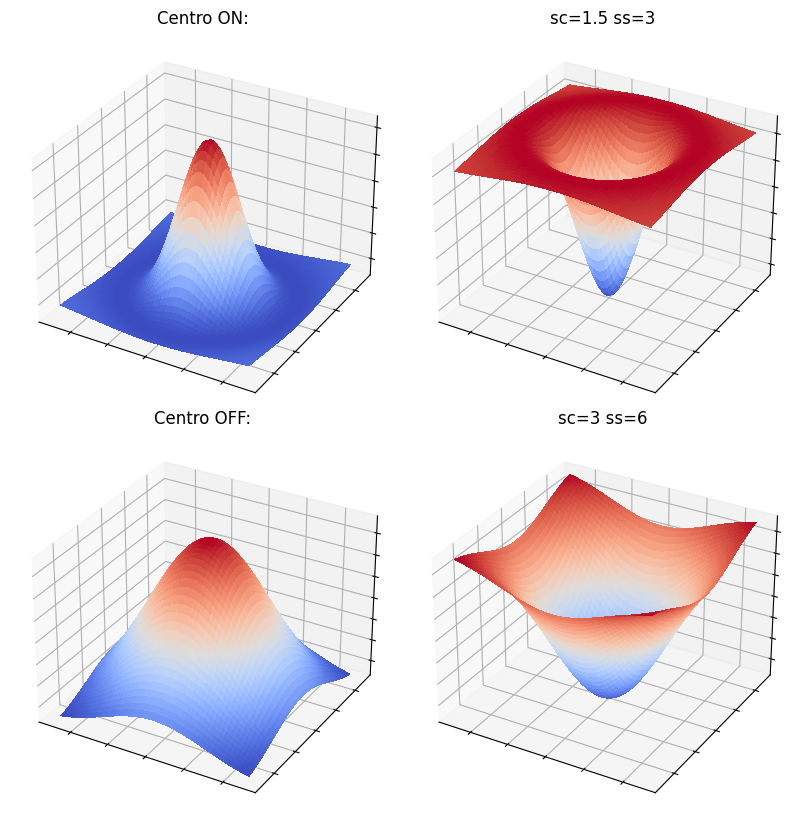

In [469]:
# DoG values 
dog_sigma = {
    0:{
        'sc':1.5,
        'ss':3
    },
    1:{
        'sc':3,
        'ss':6
    }
}

dog_size = {
    0:15,
    1:25
}

X = np.arange(-5,5,0.1)
Y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize=(8,8))
row_subfigs = fig.subfigures(2,2, wspace=0.07, hspace=0.07)

for i, row in enumerate(row_subfigs):
    if(i):
        etiqueta = 'OFF'
    else:
        etiqueta = 'ON'
    t_sc = dog_sigma[i]['sc']
    t_ss = dog_sigma[i]['ss']
    Z = (1/(2*pi*t_sc**2))*exp(-(X**2 + Y**2)/(2*t_sc**2)) - (1/(2*pi*t_ss**2))*exp(-(X**2 + Y**2)/(2*t_ss**2))
    for j,side in enumerate(row):
        axs = side.subplots(subplot_kw={"projection":"3d"})
        axs.tick_params(left = False, right = False , labelleft = False,labelbottom = False, bottom = False)
        if(j):
            Z = -Z
            axs.set_title('sc={} ss={}'.format(t_sc, t_ss))
        else:
            axs.set_title('Centro {}:'.format(etiqueta))
        surf = axs.plot_surface(X,Y,Z, cmap=color_cm.coolwarm, linewidth=0, antialiased=False)
fig.tight_layout()
plt.show()

Dado que el campo receptivo se puede modelar como una DoG, se puede utilizar biblioteca *OpenCV* para realizar la convolución del campo con la imagen. Para ejemplificar se utiliza la imagen 'g_tiger.jpg':

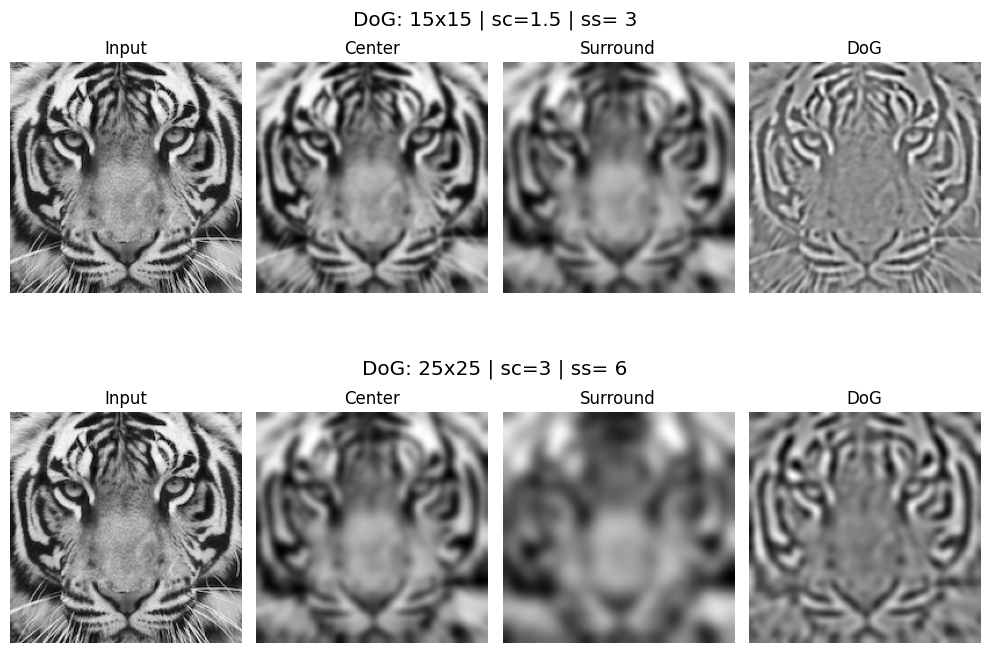

In [495]:
demo_img = cv2.imread(os.path.join(IMG_FOLDER,'g_tiger.jpg'),0)
demo_img = demo_img.astype(np.float32)

#fig, axs = plt.subplots(2,4)
fig = plt.figure(figsize=(10,7))
subfigs = fig.subfigures(2,1)

for dog in dog_sigma:
    subfigs[dog].suptitle('DoG: {}x{} | sc={} | ss= {}'.format(dog_size[dog],dog_size[dog],dog_sigma[dog]['sc'], dog_sigma[dog]['ss']),fontsize='x-large')
    axs = subfigs[dog].subplots(1,4)
    center = cv2.GaussianBlur(demo_img,(dog_size[dog],dog_size[dog]), dog_sigma[dog]['sc'])
    surround = cv2.GaussianBlur(demo_img, (dog_size[dog],dog_size[dog]), dog_sigma[dog]['ss'])
    DoG = center-surround

    axs[0].imshow(demo_img, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(center, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Center')

    axs[2].imshow(surround, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title('Surround')

    axs[3].imshow(DoG, cmap='gray')
    axs[3].axis('off')
    axs[3].set_title('DoG')

    #subfigs[dog].tight_layout()

fig.tight_layout()
plt.show()

De esta forma, los valores obtenidos de la DoG, corresponden a los valores de corriente buscados. Note que dada la relación entre $D_{ON}$ y $D_{OFF}$, las corrientes poseen esta misma relación: $I_{ON} = - I_{OFF}$. Los modelos de neurona utilizados, corresponde a *Leaky Integrate and Fire* (LIF), los que reciben un valor de voltaje como entrada, note que en este caso, podemos definir una resistencia $R$ con valor unitario para realizar la conversión a voltaje. También se puede definir un factor de ajuste, para realizar la conversión de píxeles a corriente, en este caso se ha dejado con un valor unitario. A continuación se ejemplifica el proceso de conversión:

In [527]:
def px2V(img, k_size, sc, ss, I_size, factor=1, r=1):
    img = img.astype(np.float32)
    center = cv2.GaussianBlur(img,(k_size,k_size), sc)
    surround = cv2.GaussianBlur(img, (k_size,k_size), ss)
    DoG = center-surround
    DoG = cv2.resize(DoG, dsize=(I_size, I_size), interpolation=cv2.INTER_AREA)
    I_ON = factor*DoG
    I_OFF = factor*(-1)*DoG
    v0_ON_vals = r*I_ON*mV
    v0_OFF_vals = r*I_OFF*mV
    return v0_ON_vals, v0_OFF_vals

## Capas ON/OFF:

Se pide generar redes con 4096/2048 neuronas asociadas a las redes ON/OFF a utilizar. Para ello se implementa la siguiente función la cual genera las redes necesarias y retorna los spikes generados en las condiciones solicitadas:

In [517]:
def proccessNetwork(I_size, VON, VOFF , duration=1*second, tau=10*ms, vt=0.8*mV):
    start_scope()
    n = 2*I_size*I_size # Number of neurons derived from current array size to be used
    eqs = '''
    dv/dt = (v0 - v) / tau : volt (unless refractory)
    v0 : volt
    x: 1
    y: 1
    '''
    G = NeuronGroup(n, eqs, threshold='v>vt', reset='v= 0*mV', refractory=5*ms, method='exact')
    ON = G[0:n//2]
    OFF = G[n//2:n]
    G.v0 = np.zeros((1,n))
    G.x = np.zeros((1,n)) 
    G.y = np.zeros((1,n)) 

    # Assign current to neurons
    assigned = []
    
    for m in range(n//2):
        pix_pos = random_index(assigned, I_size)
        assigned.append(pix_pos)
        j,k = pix_pos

        ON.x[m] = j
        ON.y[m] = k
        ON.v0[m] = VON[j][k]

        OFF.x[m] = j
        OFF.y[m] = k
        OFF.v0[m] = VOFF[j][k]


    spikes = SpikeMonitor(G)
    run(duration)


    return ON,OFF,spikes

def random_index(assigned, I_size):
    original_len = len(assigned)
    while(len(assigned) != original_len+1):
        i = np.random.randint(0,I_size,dtype=int)
        j = np.random.randint(0,I_size,dtype=int)
        temp = (i,j)
        if(temp not in assigned):
            return temp


## Decoding

### LUT:


In [503]:
def LUT_generator(monitor,neuron_number= 600, DECAY=128):
    LUT = {}
    ordered_neurons = {}
    neurons_spikes = {}
    base_dict = monitor.all_values()['t']
    t_spikes = 0
    # Check neurons that generated spikes
    for neuron in base_dict.keys():
        spike_times = base_dict[neuron]
        spike_times.sort()
        n_spikes = len(spike_times)
        if(n_spikes > 0):
            ordered_neurons[neuron] = spike_times[0]
            neurons_spikes[neuron] = n_spikes
            t_spikes += n_spikes
    sorted_neurons = sorted(ordered_neurons.items(), key=lambda x:x[1])
    # Check time for first neuron_number spikes and get neurons
    count = 0
    firts_neurons = []
    for neuron in sorted_neurons:
        neuron = neuron[0]
        count += 1
        firts_neurons.append(neuron)
        if(count == neuron_number):
            time_limit = base_dict[neuron][0]
            break
    
    # Assign to the first neuron_number of neurons a decaying value based on DECAY
    for i,nnn in enumerate(firts_neurons):
        temp = 0
        for spike in base_dict[nnn]:
            if(spike <= time_limit):
                temp +=1
        LUT[nnn] = DECAY*exp(-(i)/neuron_number)
    return LUT

## Recover Image

In [522]:
def decodeSpikes(img,I_size, kernel_size, sigma_c, sigma_s, ON, OFF, spikes, LUT,scale_color=1):
    n = 2*I_size**2
    gray_img = 128*np.ones( (I_size,I_size,1), dtype=np.uint8)
    gray_img = gray_img.astype(np.float32)
    for neuron in LUT:
        if (neuron >= n//2):
            gray_img[int(OFF.x[neuron-n//2])][ int(OFF.y[neuron-n//2])] -= scale_color*LUT[neuron]
        else:
            gray_img[int(ON.x[neuron])][ int(ON.y[neuron])] += scale_color*LUT[neuron]

    C_POST = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), sigma_c)
    S_POST = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), sigma_s)
    DoG_POST = (C_POST - S_POST)

    fig, axs = plt.subplots(1,4)

    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(gray_img, cmap=plt.get_cmap('gray'),vmin=0,vmax=255)
    axs[2].imshow(DoG_POST, cmap=plt.get_cmap('gray'),vmin=DoG_POST.min(),vmax=DoG_POST.max())
    axs[3].imshow(DoG, cmap=plt.get_cmap('gray'),vmin=DoG.min(),vmax=DoG.max())
    plt.show()


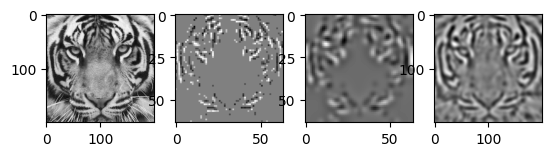

In [528]:
def fullProcess(img_name,k_size, sc, ss, I_size):
    img = cv2.imread(os.path.join(IMG_FOLDER, img_name),0)
    v_ON, V_OFF = px2V(img, k_size, sc, ss, I_size)
    
    ON, OFF, spikes = proccessNetwork(I_size, v_ON, V_OFF)
    
    LUT = LUT_generator(spikes)
    decodeSpikes(img, I_size, k_size, sc, ss, ON, OFF, spikes, LUT)


fullProcess('g_tiger.jpg', 15, 1.5, 3, 64)
    

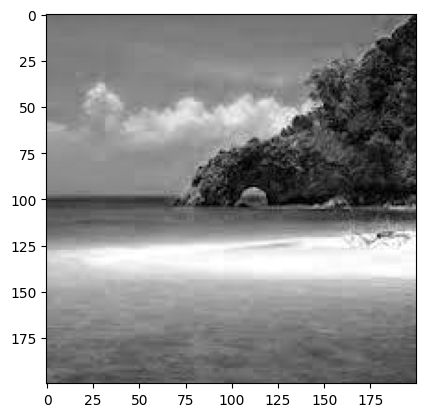

In [365]:
img = cv2.imread('images/g_beach.jpg',0)
plt.imshow(img,cmap='gray')
plt.show()

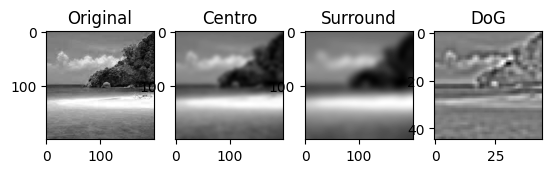

Center shape: (200, 200)
Surround shape: (200, 200)


In [366]:
img = img.astype(np.float32)

sigma_c1 = 3
sigma_s1 = 6

kernel_size = 25
 
I_size = 45 # tamaño de la nueva "imagen" de corrientes para DoG

# Normalize the pixel values to 0-1
center = cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma_c1)
surround = cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma_s1)
DoG = center - surround

# Downsampling de corrientes
DoG = cv2.resize(DoG, dsize=(I_size, I_size), interpolation=cv2.INTER_AREA) 

fig, axs = plt.subplots(1,4)

# Original
axs[0].imshow(img,cmap='gray')
axs[0].set_title('Original')
# Center 
axs[1].imshow(center, cmap='gray')
axs[1].set_title('Centro')
#Surround 
axs[2].imshow(surround, cmap='gray')
axs[2].set_title('Surround')
#DoG
axs[3].imshow(DoG, cmap='gray')
axs[3].set_title('DoG')

plt.show()

print('Center shape: {}'.format(center.shape))
print('Surround shape: {}'.format(surround.shape))

## Conversión a Corriente

In [367]:
factor = (1)
r = 1
I_ON = factor*DoG
I_OFF = factor*(-1)*DoG
v0_ON_vals = r*I_ON*mV
v0_OFF_vals = r*I_OFF*mV

print(I_ON[0][0])
print(I_OFF[0][0])

-2.2117183
2.2117183


## Redes ON/OFF

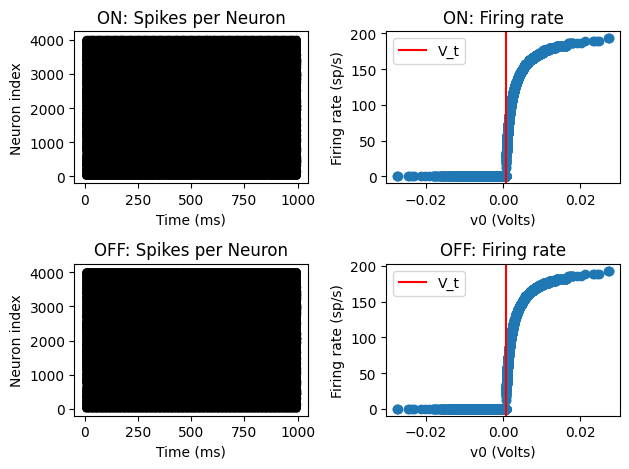

In [368]:
start_scope()

n = 2*I_size*I_size
duration = 1*second
tau = 10*ms
vt = 0.8*mV

coor_spikes = {}

eqs = '''
dv/dt = (v0 - v) / tau : volt (unless refractory)
v0 : volt
x: 1
y: 1
'''
G = NeuronGroup(n, eqs, threshold='v>vt', reset='v= 0*mV', refractory=5*ms, method='exact')
ON = G[0:n//2]
OFF = G[n//2:n]

G.v0 = np.zeros((1,n))
G.x = np.zeros((1,n)) 
G.y = np.zeros((1,n)) 

### REVISAAAAAR
""" k = 0
j = 0
for m in range(n//2):

    k = m//I_size
    if(j >= I_size):
        j = 0

    ON.x[m] = k
    ON.y[m] = j
    OFF.x[m] = k
    OFF.y[m] = j
    
    ON.v0[m] = v0_ON_vals[k][j]
    OFF.v0[m] = v0_OFF_vals[k][j]
    j += 1
 """

assigned = []
def random_index(assigned):
    original_len = len(assigned)
    while(len(assigned) != original_len+1):
        i = np.random.randint(0,I_size,dtype=int)
        j = np.random.randint(0,I_size,dtype=int)
        temp = (i,j)
        if(temp not in assigned):
            return temp

for m in range(n//2):
    test = random_index(assigned)
    assigned.append(test)
    j,k = test

    ON.x[m] = j
    ON.y[m] = k
    ON.v0[m] = v0_ON_vals[j][k]

    OFF.x[m] = j
    OFF.y[m] = k
    OFF.v0[m] = v0_OFF_vals[j][k]

spikes = SpikeMonitor(G)

run(duration)

#figure(figsize=(12,4))
fig, axs = plt.subplots(2,2)

# ON - spikes per neuron
axs[0][0].plot(spikes.t/ms, spikes.i, '.k')
axs[0][0].set_xlabel('Time (ms)')
axs[0][0].set_ylabel('Neuron index')
axs[0][0].set_title('ON: Spikes per Neuron')
# ON - firing rate
axs[0][1].scatter(G.v0, spikes.count/duration)
axs[0][1].set_xlabel('v0 (Volts)')
axs[0][1].set_ylabel('Firing rate (sp/s)')
axs[0][1].set_title('ON: Firing rate')  
axs[0][1].axvline(x=float(vt), color='r', label='V_t')
axs[0][1].legend()

# OFF - spikes per neuron
axs[1][0].plot(spikes.t/ms, spikes.i, '.k')
axs[1][0].set_xlabel('Time (ms)')
axs[1][0].set_ylabel('Neuron index')
axs[1][0].set_title('OFF: Spikes per Neuron')
# ON - firing rate
axs[1][1].scatter(G.v0, spikes.count/duration)
axs[1][1].set_xlabel('v0 (Volts)')
axs[1][1].set_ylabel('Firing rate (sp/s)')
axs[1][1].set_title('OFF: Firing rate')
axs[1][1].axvline(x=float(vt), color='r', label='V_t')
axs[1][1].legend()  

plt.tight_layout()
plt.show()

In [369]:
def LUT_generator(monitor,neuron_number= 600):
    LUT = {}
    ordered_neurons = {}
    neurons_spikes = {}
    base_dict = monitor.all_values()['t']
    t_spikes = 0
    # Check neurons that generated spikes
    for neuron in base_dict.keys():
        spike_times = base_dict[neuron]
        spike_times.sort()
        n_spikes = len(spike_times)
        if(n_spikes > 0):
            ordered_neurons[neuron] = spike_times[0]
            neurons_spikes[neuron] = n_spikes
            t_spikes += n_spikes

    sorted_neurons = sorted(ordered_neurons.items(), key=lambda x:x[1])
    
    count = 0
    firts_neurons = []
    for neuron in sorted_neurons:
        neuron = neuron[0]
        count += 1
        firts_neurons.append(neuron)
        if(count == neuron_number):
            time_limit = base_dict[neuron][0]
            #print(time_limit)
            break
        #LUT[neuron] = np.uint8(neurons_spikes[neuron])#75*neuron s_spikes[neuron]#(127*neurons_spikes[neuron]/t_spikes)

    DECAY  = 128

    for i,nnn in enumerate(firts_neurons):
        temp = 0
        for spike in base_dict[nnn]:
            if(spike <= time_limit):
                temp +=1
        LUT[nnn] = DECAY*exp(-(i)/neuron_number)

    return LUT

LUT = LUT_generator(spikes)


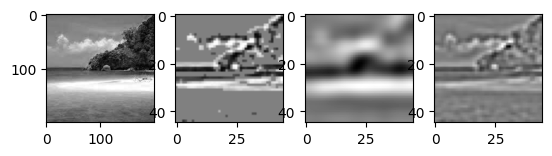

-23.008461


In [370]:
gray_img = 128*np.ones( (I_size,I_size,1), dtype=np.uint8)
gray_img = gray_img.astype(np.float32)
scale_color = 1
#print(LUT.keys())
for neuron in LUT:
    temp_sum = int(gray_img[int(G.x[neuron])][ int(G.y[neuron])])
    if (neuron >= n//2):
        if(temp_sum - scale_color*LUT[neuron] < 0):
            gray_img[int(OFF.x[neuron-n//2])][ int(OFF.y[neuron-n//2])] = 0
        else:
            gray_img[int(OFF.x[neuron-n//2])][ int(OFF.y[neuron-n//2])] -= scale_color*LUT[neuron]
    else:
        if(temp_sum + scale_color*LUT[neuron] > 255):
            gray_img[int(ON.x[neuron])][ int(ON.y[neuron])] = 255
        else:
            gray_img[int(ON.x[neuron])][ int(ON.y[neuron])] += scale_color*LUT[neuron]

C_POST = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), sigma_c1)
S_POST = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), sigma_s1)
DoG_POST = (C_POST - S_POST)

fig, axs = plt.subplots(1,4)

axs[0].imshow(img, cmap='gray')
axs[1].imshow(gray_img, cmap=plt.get_cmap('gray'),vmin=0,vmax=255)
axs[2].imshow(DoG_POST, cmap=plt.get_cmap('gray'),vmin=DoG_POST.min(),vmax=DoG_POST.max())
axs[3].imshow(DoG, cmap=plt.get_cmap('gray'),vmin=DoG.min(),vmax=DoG.max())
plt.show()
